# Análise das notícias sob a ótica ESG: geração da base com sentimentos

- Autor: Daniel Saraiva Leite - 2023
- Projeto Análise de sentimentos sobre notícias do tema ESG
- Trabalho de conclusão de curso - MBA Digital Business USP Esalq

In [1]:
import warnings
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import datetime  as dt
from scipy import interpolate
import scipy.stats
from noticias_timeline import plota_timeline
from noticias_processamento_texto import *
from analise_sentimento_modelo import *
from analise_sentimento_modelo_gpt import *
from noticias_graficos import *
from analise_sentimento_modelo_gpt import *
from classificador_esg import aplica_classificador_esg
import pickle

warnings.filterwarnings('ignore')
base_noticias = 'datasets/base_noticias.xlsx'
base_noticias_saida = 'datasets/sentimento_base_noticias.xlsx'
base_noticias_saida_short = 'datasets/sentimento_base_noticias_short.xlsx'
caminho_cache='datasets/gpt_cache.xlsx'

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/danielsaraivaleite/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielsaraivaleite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielsaraivaleite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lendo base de notícias

In [2]:
df = pd.read_excel(base_noticias)

df['fonte'] = df['fonte'].apply(trata_nome_fontes)
df['data_publicacao'] = df['data_publicacao'].dt.date
df = df.sort_values(by=['empresa', 'data_publicacao'])
df['titulo_par'] = df['titulo'].str.strip().apply(remove_acentos).str[:15]
df = df.drop_duplicates(subset=['empresa', 'fonte', 'data_publicacao', 'titulo_par'], keep='first')
del df['titulo_par']

# ajustes
df = ajusta_nomes_empresas_dataframe(df)

# cria hash
df['hash'] = df.apply(lambda row: criar_hash_noticia(row['texto_completo'], row['empresa'], titulo=row['titulo'], data=row['data_publicacao']), axis=1)


## Aplicação Classificador SVM

In [3]:
# utiliza o classificador por ML para determinar o assunto da noticia: E, S, G ou outros
vect = pickle.load(open('models/SVCC=0.2, kernel=linear, probability=True_vectorizer_esg_classifier.sav', 'rb'))
model = pickle.load(open('models/SVCC=0.2, kernel=linear, probability=True_classifier_esg_classifier.sav', 'rb'))

if len(df.loc[ (pd.isnull(df['classificacao_ml']) &   (~pd.isnull(df['texto_completo']))), 'classificacao_ml']) >0:
    df.loc[ (pd.isnull(df['classificacao_ml']) &   (~pd.isnull(df['texto_completo']))), 'classificacao_ml'] = aplica_classificador_esg(vect, model, 
                                                                                                              df.loc[ (pd.isnull(df['classificacao_ml']) &   (~pd.isnull(df['texto_completo'])))], 
                                                                                                              comparar_com_real=False, col_texto_origem='texto_completo', 
                                                                                                              col_texto_saida='texto_ajustado', col_classe_verdadeira='classificacao')   
    
# salva na base original para cache
df.to_excel(base_noticias, index=False)

## Aplicação do CHAT GPT

In [4]:
df = pd.read_excel(base_noticias)

# abre o cache
df_cache = pd.read_excel(caminho_cache)
dic_cache = df_cache.set_index('hash')['resposta'].to_dict()
tam_inicial = len(dic_cache)


try:
    df['gpt_resposta_completa'] = df.apply(lambda row: classifica_sentimento_noticia_gpt(row['data_publicacao'], row['titulo'], row['texto_completo'], row['empresa'], dicionario_cache=dic_cache)  if (  (not pd.isnull(row['texto_completo'])) and row['classificacao_ml'] != 'Outros' and ( pd.isnull(row['gpt_resposta_completa'])) ) else row['gpt_resposta_completa'], axis=1)
finally:                                                                    
    #salva o cache do gpt
    tam_final = len(dic_cache)
    print('Realizadas ' + str(tam_final - tam_inicial) + ' chamadas à API do GPT.')
    df_cache = pd.DataFrame({'hash': dic_cache.keys(),  'resposta': dic_cache.values()})
    df_cache.to_excel(caminho_cache, index=False)

# faz os filtros
df.to_excel(base_noticias, index=False)
df = df[~pd.isnull(df['texto_completo'])]
df = df[df['classificacao_ml'] != 'Outros']  

# tratando
df = gera_colunas_gpt(df, coluna_resposta_gpt='gpt_resposta_completa')
df = filtros_pos_gpt(df)
df['polaridade'] = df['gpt_polaridade']  # substitui metodo anterior
# resumos vazios
df['gpt_resumo'] = df.apply(lambda row: row['titulo'] if pd.isnull(row['gpt_resumo']) else row['gpt_resumo'] , axis=1)

df['gpt_lista_respostas'] = df['gpt_lista_respostas'].astype(str)  # para permitir remover duplicatas
df = filtrar_noticias_pos_coleta_modelo_simplificado(df)

df.to_excel(base_noticias_saida, index=False)

# versao reduzida para o site
df_short = df.loc[: , ['hash', 'titulo', 'data_publicacao', 'url', 'fonte', 'empresa', 'classificacao', 'gpt_resumo', 'polaridade']]
df_short.to_excel(base_noticias_saida_short, index=False)


Realizadas 61 chamadas à API do GPT.


## Descrevendo o conjunto de dados

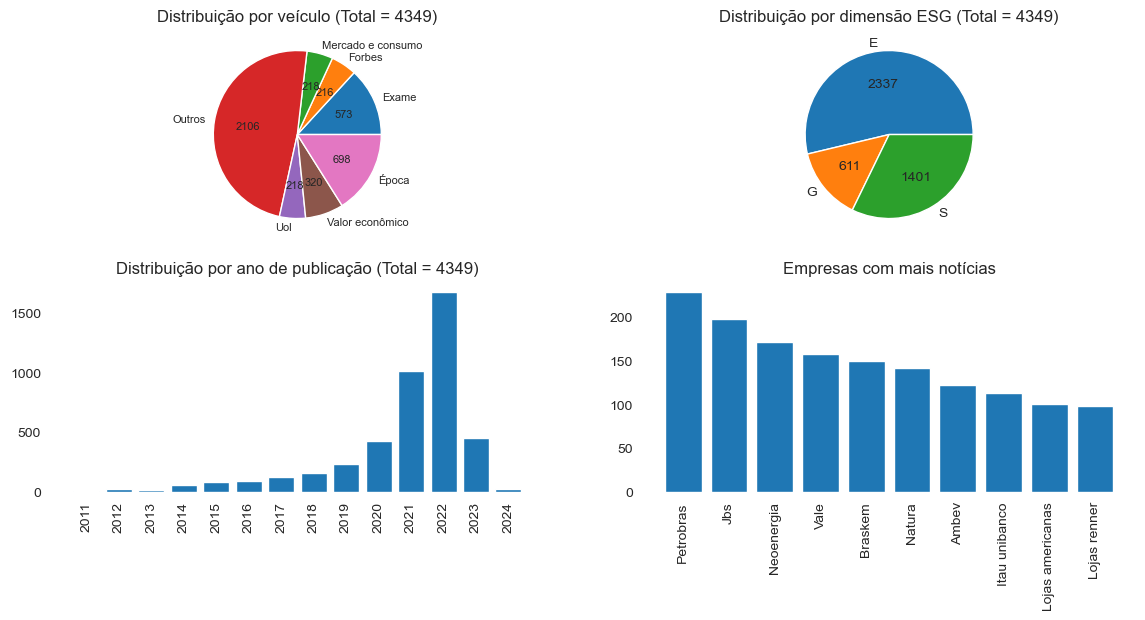

In [5]:
df = pd.read_excel(base_noticias_saida)

    
plotar_descricao_base(df, plotar_histograma=False, arquivo=r'static/images/descricao_base.png')

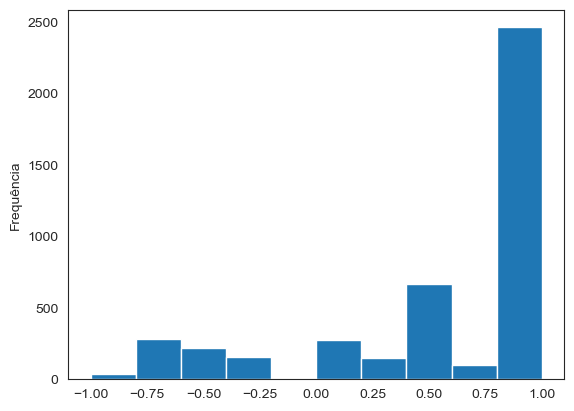

In [6]:
df['polaridade'].plot.hist().set_ylabel('Frequência')
plt.savefig(r'static/images/histograma_base.png', bbox_inches='tight')
plt.show()

## Definindo a empresa para análise específica

In [7]:
empresa = 'itau unibanco'
dfEmpresa = df[df['empresa'] == empresa]

## Executando o modelo de polaridade média (EWMA)

In [8]:
calibragem_alfa = [0.07, 0.075, 0.1, 0.15]

In [9]:
lista_dfs_polaridade = [gera_curva_polaridade_media(df, empresa, 'ESG', alfa=calibragem_alfa[0]),
                        gera_curva_polaridade_media(df, empresa, 'E', alfa=calibragem_alfa[1]),
                        gera_curva_polaridade_media(df, empresa, 'S', alfa=calibragem_alfa[2]),
                        gera_curva_polaridade_media(df, empresa, 'G', alfa=calibragem_alfa[3])]

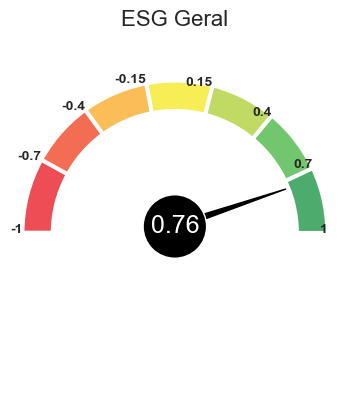

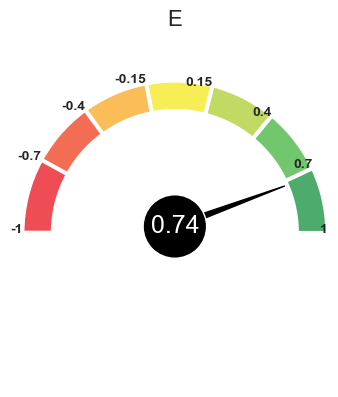

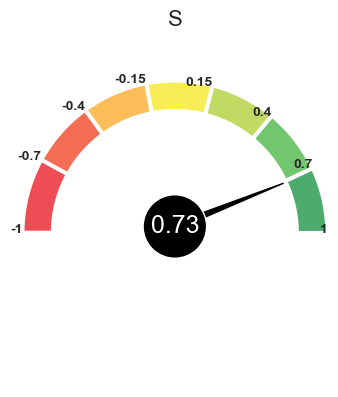

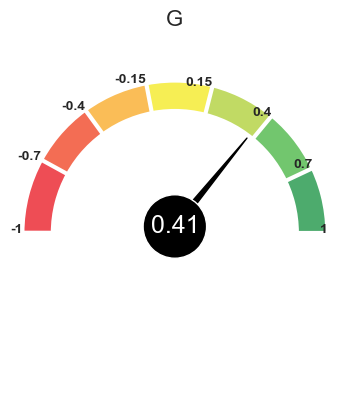

In [10]:
plotar_gauge_polaridade(df, empresa=empresa, dimensao='ESG', df_pol=lista_dfs_polaridade[0])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='E', df_pol=lista_dfs_polaridade[1])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='S', df_pol=lista_dfs_polaridade[2])
plotar_gauge_polaridade(df, empresa=empresa, dimensao='G', df_pol=lista_dfs_polaridade[3])

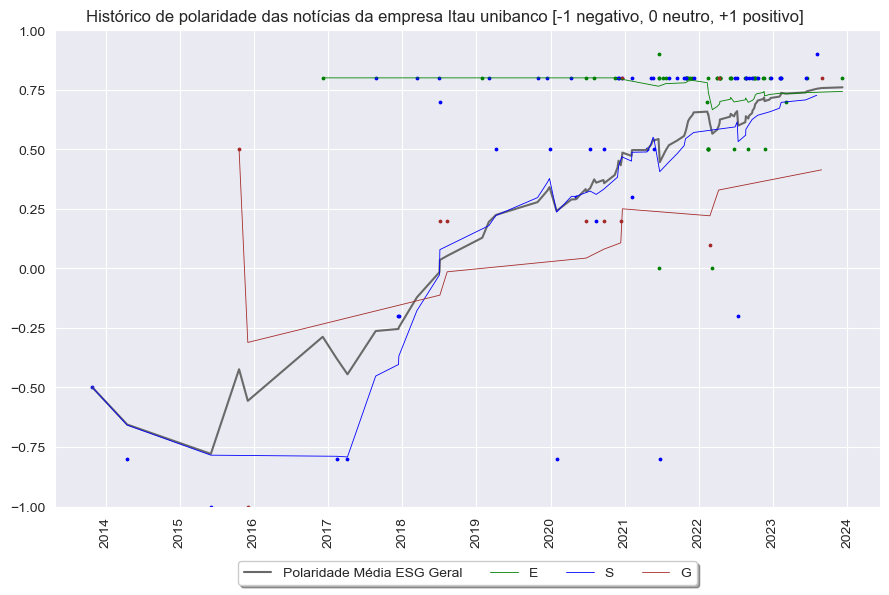

In [11]:
plota_polaridade_media_sintetico(df, empresa, arquivo=r'static/images/pol_media_sintetico.png', lista_dfs_polaridade=lista_dfs_polaridade)

## Amostra de notícias para a empresa

20/10/2015: Roberto Setubal, o estrategista: o melhor executivo do Brasil - Época NEGÓCIOS [G 0.50]
05/12/2016: Hoje é o mundo do E e não do OU que impera, diz Fábio Barbosa - Época NEGÓCIOS [E 0.80]
23/08/2017: Cubo muda para sede quatro vezes maior e quer receber até 2 mil pessoas por dia - Época NEGÓCIOS [S 0.80]
14/03/2018: Denise Hills: "Mulheres avançaram em protagonismo, mas não em autoestima" - Época NEGÓCIOS [S 0.80]
03/07/2018: Novo prédio do Cubo terá mais de 200 startups - Época NEGÓCIOS [S 0.80]
29/10/2019: Itaú Unibanco é destaque do ano no Valor Carreira - Valor Econômico [S 0.80]
16/12/2019: Robô descobre futuro cada vez mais humano na campanha de final ... - ADNEWS [S 0.80]
03/08/2020: Itaú garante consumo de eletricidade 100% renovável com compra de RECs - Valor Econômico [E 0.80]
12/11/2020: Itaú lança serviço de carro elétrico compartilhado que tem até BMW - Exame Notícias [E 0.80]
16/06/2021: Itaú Unibanco anuncia R$ 400 bilhões para desenvolvimento sustentável - P

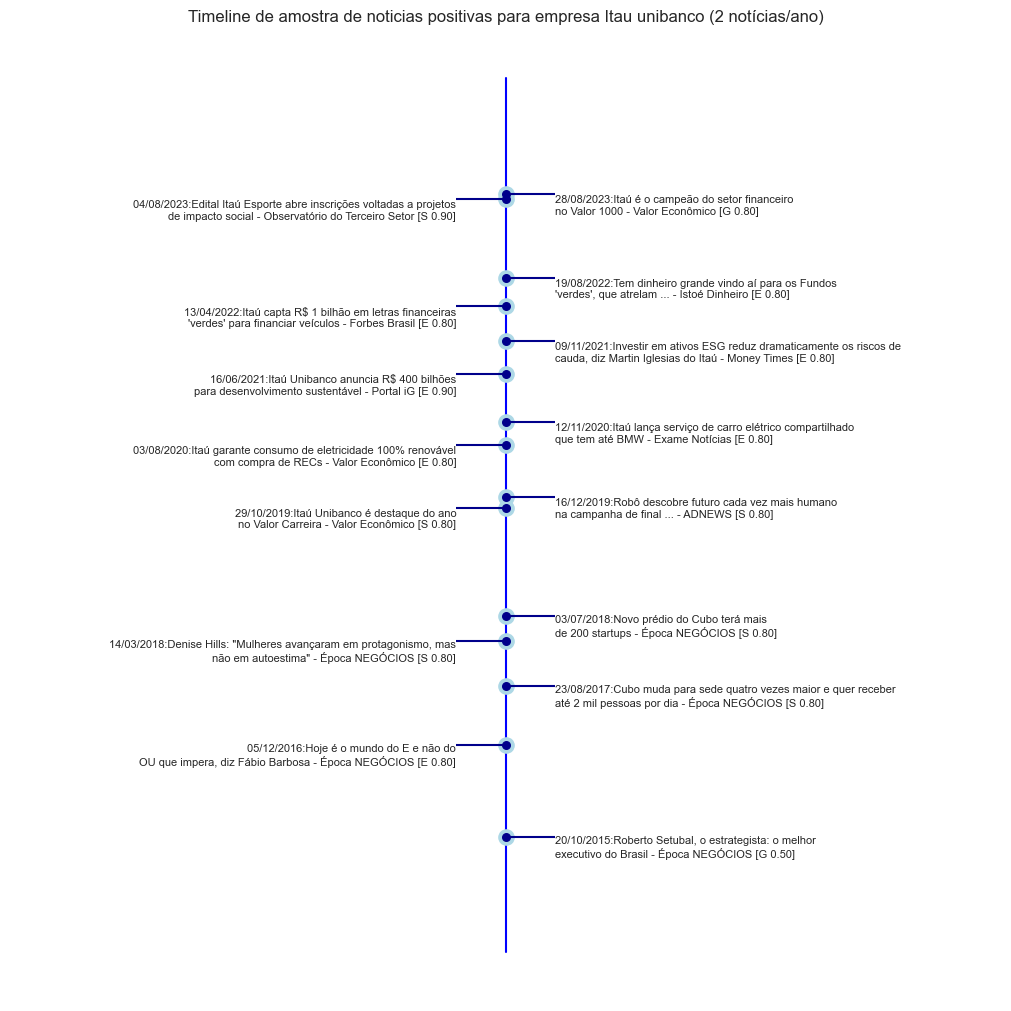

In [12]:
plota_timeline_polaridade(dfEmpresa, +1, 2, empresa )

28/10/2013: Bancário receberá R$ 30 mil por não receber prêmios depois de ficar 30 anos no Itaú - Época NEGÓCIOS [S -0.50]
17/04/2014: Itaú é condenado em R$ 21 mi por proibir que funcionários tirem 30 dias de férias - Época NEGÓCIOS [S -0.80]
03/06/2015: Itaú é processado em R$ 20 milhões após funcionária grávida abortar em agência - Época NEGÓCIOS [S -1.00]
02/12/2015: Tribunal condena Itaú Unibanco por orientar caixa a esconder dinheiro - Época NEGÓCIOS [G -1.00]
11/02/2017: Justiça do Trabalho condena Itaú a pagar R$ 1 milhão por assédio a funcionários - Época NEGÓCIOS [S -0.80]
06/04/2017: Gerente gay é demitido do Itaú e acusa banco de homofobia - Época NEGÓCIOS [S -0.80]
31/01/2020: Empresária, namorada de Rennan da Penha vai a banco e é levada pela polícia - UOL [S -0.80]
22/06/2021: Itaú Consignado é multado em R$ 9,6 milhões pela Secretaria do Consumidor - Época NEGÓCIOS [S -0.80]
13/07/2022: Combate a assédio nas empresas passa por cultura e ambiente menos estressante e inse

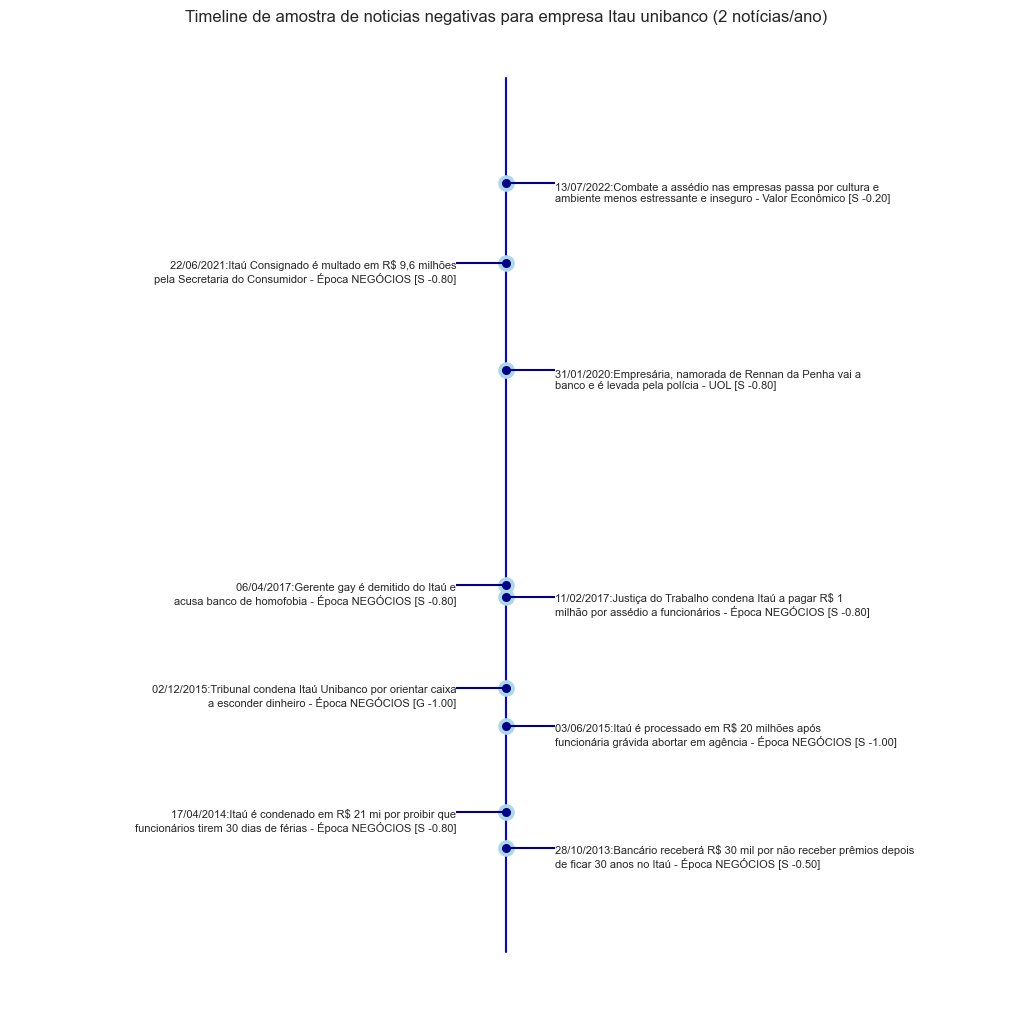

In [13]:
plota_timeline_polaridade(dfEmpresa, -1, 2, empresa )

## Comparativo com Polaridade com rankings mercado

Media ano: 13


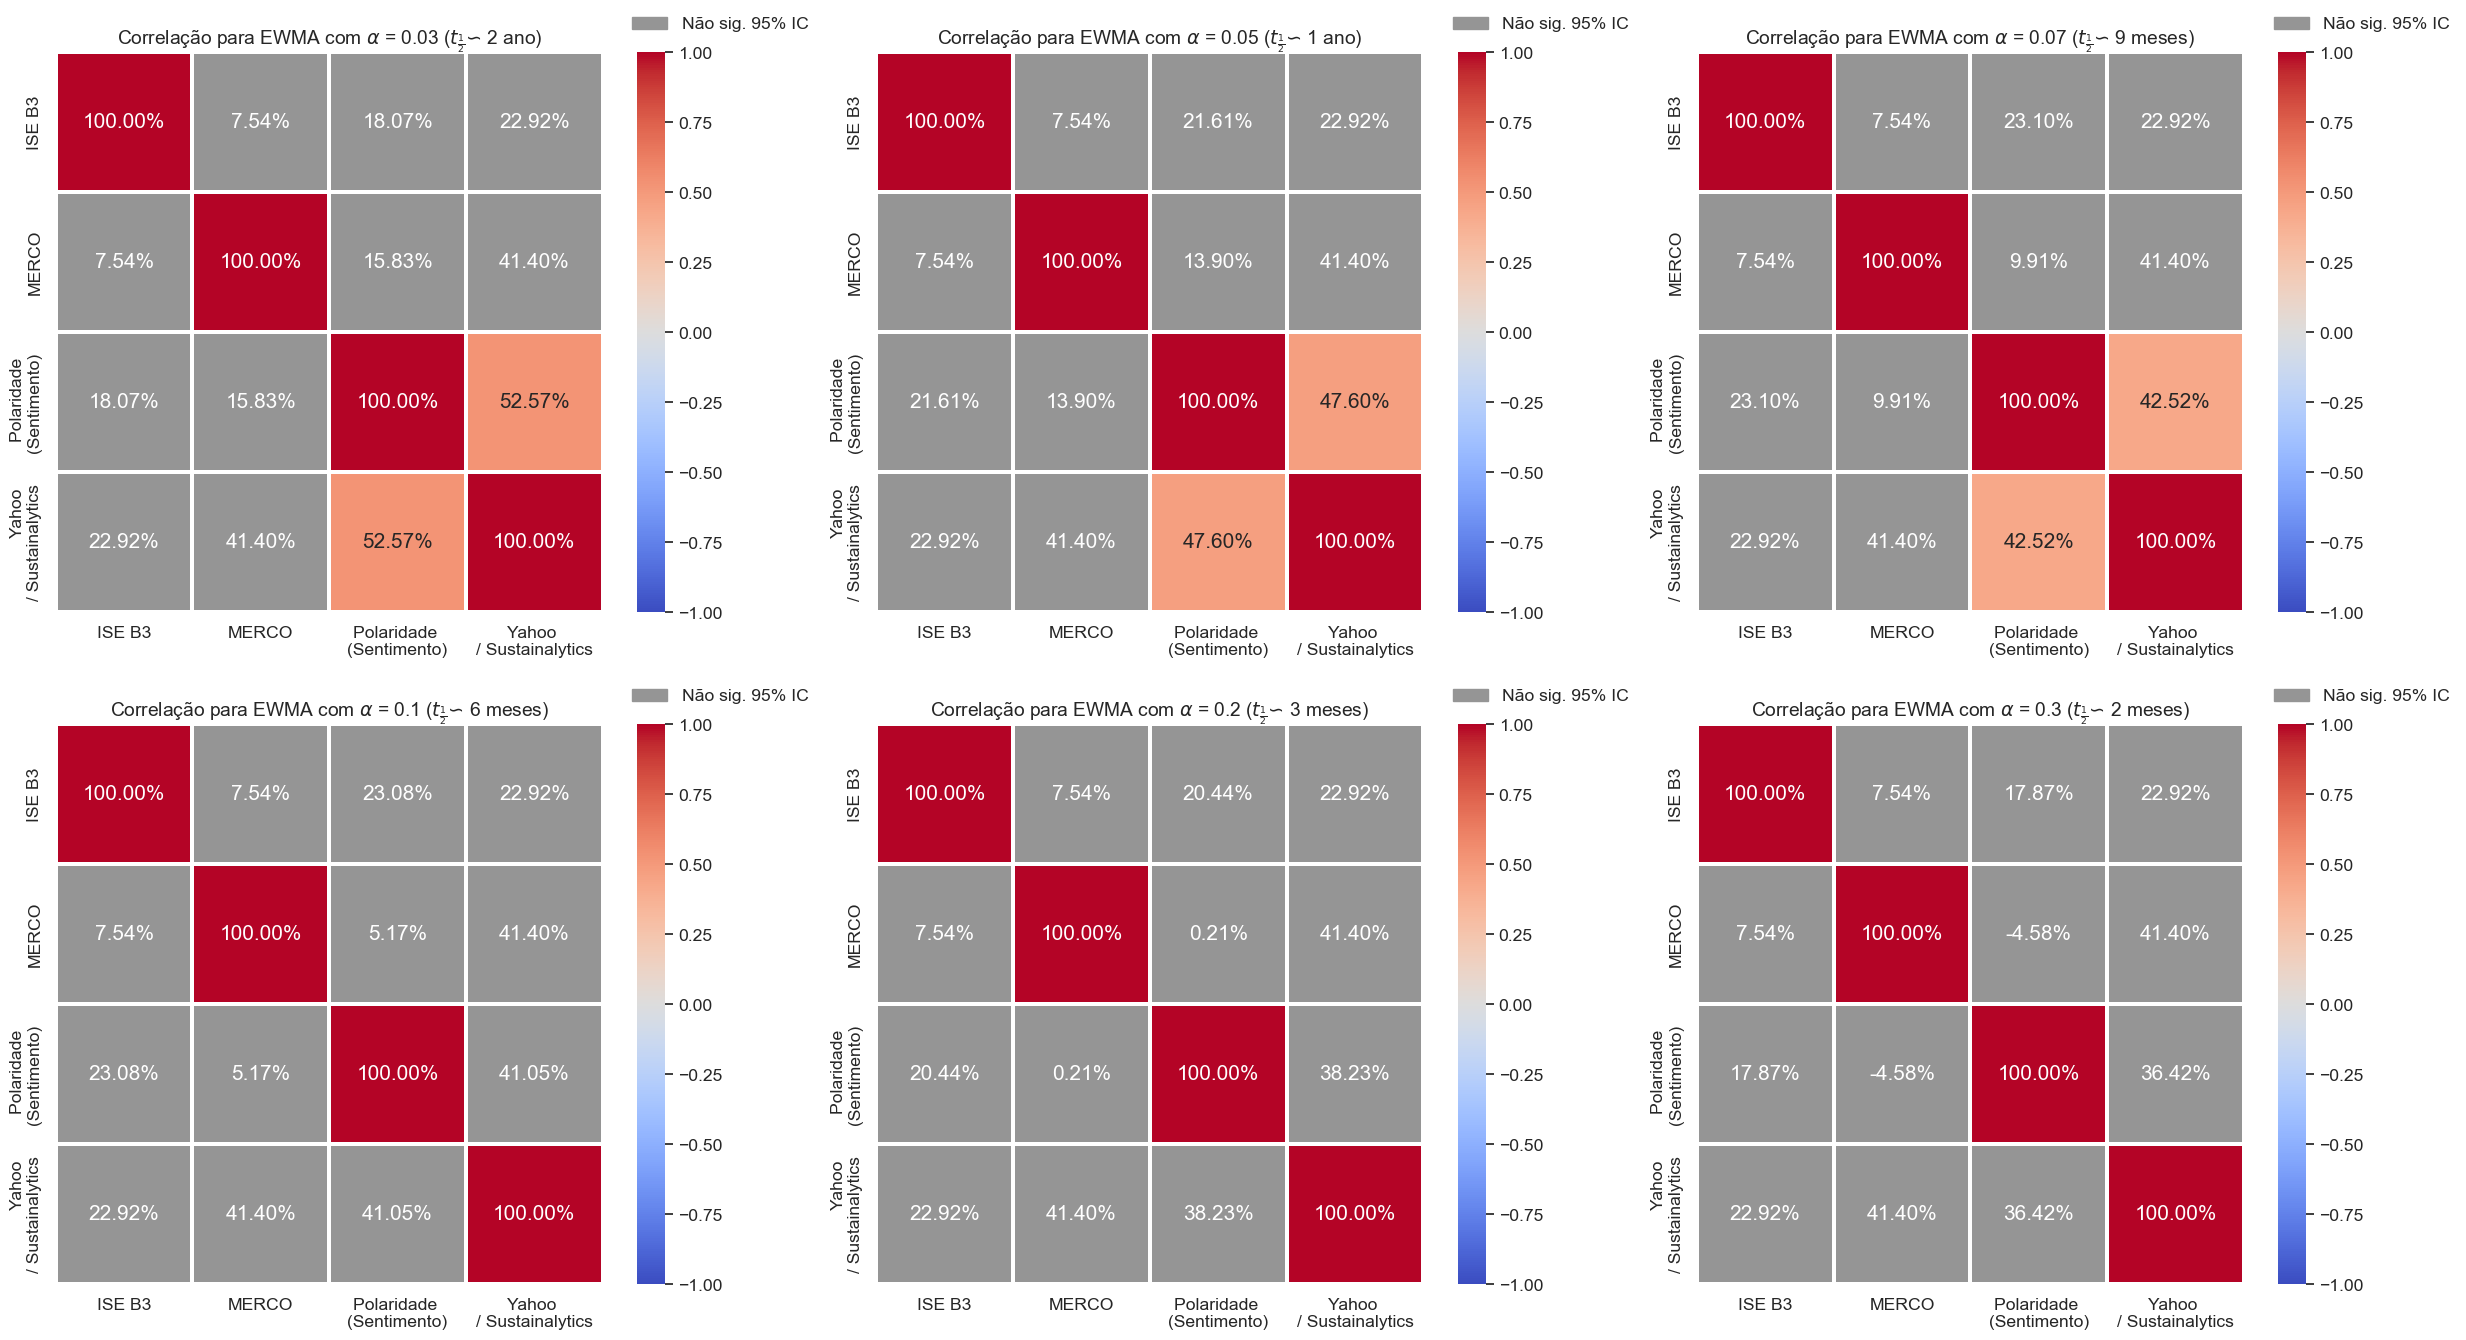

In [14]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count().mean().iloc[0]
media_ano = round(media_ano)
print('Media ano: ' + str(media_ano))

dfB3 = None

dfEmpresasComparar = pd.read_excel('datasets/lista_empresas.xlsx')
dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=pd.read_excel('datasets/EscoreMerco.xlsx'), on='Nome', how='left')

df_yahoo = pd.read_excel('datasets/escore_yahoo.xlsx')
df_yahoo = df_yahoo[df_yahoo.Date.dt.date <= dt.date(2023, 1, 1)]
df_yahoo = df_yahoo[df_yahoo.Date.dt.date >= dt.date(2021, 1, 1)]
df_yahoo = pd.merge(left=df_yahoo.groupby(by=['Nome'], as_index=False)['Date'].max(), 
                   right=df_yahoo.loc[:, ['Date', 'Nome', 'Escore_Yahoo_Norm' ]], 
                   on=['Nome', 'Date'], how='left')

dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=df_yahoo, on='Nome', how='left')  #Escore_Yahoo_Norm



data_analise = dt.date(2023, 1, 1)  

dfAnalise = df[df['data_publicacao'].dt.date <= data_analise ]

dfEmpresasComparar = dfEmpresasComparar[ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) | (~pd.isnull(dfEmpresasComparar['Escore Merco']))  | (~pd.isnull(dfEmpresasComparar['Escore_Yahoo_Norm']))  ]  # somente considera B3 ou MERCO



dfEmpresasComparar['QtdeNoticias'] =  dfEmpresasComparar.apply(lambda row: len(dfAnalise[dfAnalise.empresa == remove_acentos(row['Nome'].lower())]),  axis=1)

def obtem_ultima_polaridade_base100(dfAnalise, empresa, data_analise, alfa):
    
    dfRes = gera_curva_polaridade_media(dfAnalise, empresa=remove_acentos(empresa.lower()), dimensao='ESG', alfa=alfa)
    if dfRes is not None and len(dfRes) > 0:
        return 100.0 * dfRes['polaridade_fit'].iloc[-1]
    else:
        return None
        
        
qtde_minima = 18
dfEmpresasComparar['Polaridade'] = dfEmpresasComparar.apply(lambda row: obtem_ultima_polaridade_base100(dfAnalise, row['Nome'], data_analise, alfa=0.1) if row['QtdeNoticias'] >= qtde_minima else None   , axis=1)
dfEmpresasComparar.to_excel('datasets/resultado_comp_rankings.xlsx')

rankings = {'Polaridade' : 'Polaridade (Sentimento)', 
            'SCORE ISE B3' : 'ISE B3', 
            'Escore Merco': 'MERCO', 
            'Escore_Yahoo_Norm' : 'Yahoo / Sustainalytics'}

dfEmpresasComparar = dfEmpresasComparar.loc[:, ['Nome'] + list(rankings.keys()) + ['QtdeNoticias']].drop_duplicates()

def correl_ranking(dfEmpresasComparar, a, b, p_valor=0):
    return scipy.stats.spearmanr(dfEmpresasComparar[a], dfEmpresasComparar[b])[p_valor]

df_resultado_correl = None
    
for a in [0.03, 0.05, 0.07,  0.1, 0.2, 0.3]:
    
    dfEmpresasComparar['Polaridade'] = dfEmpresasComparar.apply(lambda row: obtem_ultima_polaridade_base100(dfAnalise, row['Nome'], data_analise, alfa=a) if row['QtdeNoticias'] >= qtde_minima else None   , axis=1)    
    
    pares = [(a, b) for idx, a in enumerate(rankings.keys()) for b in list(rankings.keys())[idx + 1:]]
    for p in pares:
        
        df_correl_par = dfEmpresasComparar[['Nome', p[0], p[1]]][ (~pd.isnull(dfEmpresasComparar[p[0]])) &  (~pd.isnull(dfEmpresasComparar[p[1]])) ].drop_duplicates()
        

        correl = correl_ranking(df_correl_par, p[0], p[1])
        pvalor = correl_ranking(df_correl_par, p[0], p[1], p_valor=1)

        df_correl_par_resultado = pd.DataFrame( {'Alfa' : [a], 'Ranking A': [rankings[p[0]]],
                                                 'Ranking B': [rankings[p[1]]], 'Correlação' : correl,
                                                 'P-valor' : pvalor
                                                })
        if df_resultado_correl is None:
            df_resultado_correl = df_correl_par_resultado
        else:
            df_resultado_correl = pd.concat([df_resultado_correl, df_correl_par_resultado])

df_resultado_correl.to_excel('datasets/resultado_correlacao.xlsx', index=False)


plotar_correlacao_rankings(df_resultado_correl, qtd_media_anual=media_ano)

## Médias anuais

In [15]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
df_recente = df_recente[df_recente['classificacao'] == 'G']
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count().mean().iloc[0]
media_ano = round(media_ano)
print('Media ano geral G: ' + str(media_ano))
# 0.2

Media ano geral G: 2


In [16]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
df_recente = df_recente[df_recente['classificacao'] == 'E']
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count().mean().iloc[0]
media_ano = round(media_ano)
print('Media ano geral E: ' + str(media_ano))
# 0.075

Media ano geral E: 9


In [17]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
df_recente = df_recente[df_recente['classificacao'] == 'S']
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count().mean().iloc[0]
media_ano = round(media_ano)
print('Media ano geral S: ' + str(media_ano))
# 0.1

Media ano geral S: 5


In [18]:
df_recente = df[df.data_publicacao.dt.date >= dt.date(2021, 1, 1)]
df_recente = df_recente[df_recente.data_publicacao.dt.date <= dt.date(2022, 12, 31)]
media_ano = df_recente.groupby(by=['empresa', df_recente.data_publicacao.dt.year], as_index=False).count().mean().iloc[0]
media_ano = round(media_ano)
print('Media ano geral total: ' + str(media_ano))
# 

Media ano geral total: 13
